# Extract and load data

**Concatenate all the files to make easier the extraction**

In [28]:
#find data -type f -name "*.txt" -exec cat {} + > all_data.txt

SyntaxError: invalid syntax (3255588386.py, line 1)

**Extract locations and store them into a file**

In [29]:
import json
import pandas as pd

with open('../data/all_data.txt', 'r', encoding='latin-1') as file:
    lines = file.readlines()

latitudes = []
longitudes = []
altitudes = []
accuracies = []

for idx, line in enumerate(lines):
    try:
        data = json.loads(line)
        if not isinstance(data, dict):
            continue
    except Exception as e:
        continue

    if 'Location' in data:
        data_location = data['Location']
        latitudes.append(data_location['Latitude'])
        longitudes.append(data_location['Longtitude'])
        altitudes.append(data_location['Altitude'])
        accuracies.append(data_location['Accuracy'])

In [30]:
df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Altitude": altitudes, "Accuracy": accuracies})
# df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Accuracy": accuracies})

df_locations.drop_duplicates(inplace=True)

df_locations.to_csv("../data/locations.csv", index=False)

**Load data from the .csv file**

In [31]:
import pandas as pd
df_locations = pd.read_csv("../data/locations.csv")

df_locations['Altitude'] = df_locations['Altitude'].apply(lambda x: x/1000)
# df_locations['Latitude'] = df_locations['Latitude'].apply(lambda x: x*10)


# Clustering

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3)

kmeans.fit(df_locations.drop('Accuracy', axis=1))
df_locations['Cluster'] = kmeans.predict(df_locations.drop('Accuracy', axis=1))

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


# Define the range of cluster numbers to try
min_clusters = 2
max_clusters = 15

# Initialize variables to store the best number of clusters and the corresponding silhouette score
best_num_clusters = 0
best_silhouette_score = -1

df_sampled = df_locations.drop('Accuracy', axis=1).drop('Altitude',axis=1).sample(40000)
# Iterate over the range of cluster numbers
for num_clusters in range(min_clusters, max_clusters + 1):
    # Perform clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_sampled)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(df_sampled, kmeans.labels_)
    print("Silhouette score:", silhouette_avg, "with", num_clusters, "clusters")
    
    # Check if the current silhouette score is better than the previous best score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters

# Print the best number of clusters and the corresponding silhouette score
print("Best number of clusters:", best_num_clusters)
print("Silhouette score:", best_silhouette_score)


Silhouette score: 0.9967768124685845 with 2 clusters
Silhouette score: 0.9915973502896335 with 3 clusters
Silhouette score: 0.9886094104247491 with 4 clusters
Silhouette score: 0.9872784746940104 with 5 clusters
Silhouette score: 0.9786094473231682 with 6 clusters
Silhouette score: 0.9758503542374145 with 7 clusters
Silhouette score: 0.9699672862799235 with 8 clusters
Silhouette score: 0.9701128315179535 with 9 clusters
Silhouette score: 0.6417207185800705 with 10 clusters
Silhouette score: 0.6366812684720201 with 11 clusters
Silhouette score: 0.5861435005282096 with 12 clusters
Silhouette score: 0.5632977090449602 with 13 clusters
Silhouette score: 0.6446280705225634 with 14 clusters
Silhouette score: 0.6536414946266347 with 15 clusters
Best number of clusters: 2
Silhouette score: 0.9967768124685845


In [54]:
kmeans = KMeans(n_clusters=9)

kmeans.fit(df_locations.drop('Accuracy', axis=1))
df_locations['Cluster'] = kmeans.predict(df_locations.drop('Accuracy', axis=1))

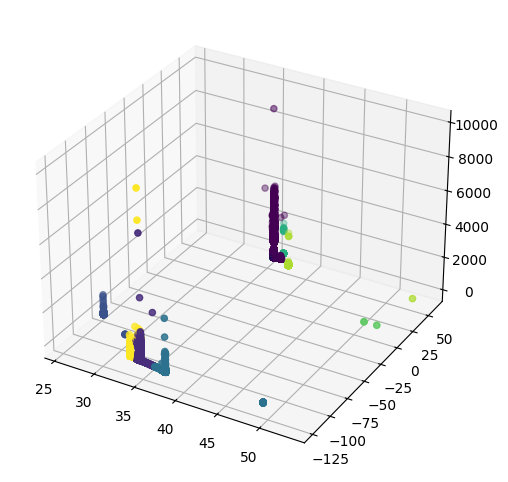

In [55]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_locations['Latitude'], df_locations['Longitude'], df_locations['Accuracy'], c=df_locations['Cluster'])
plt.show()

/var/folders/x5/spm_6r5944dfgx3qj8my0m440000gn/T/ipykernel_1184/2034884922.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


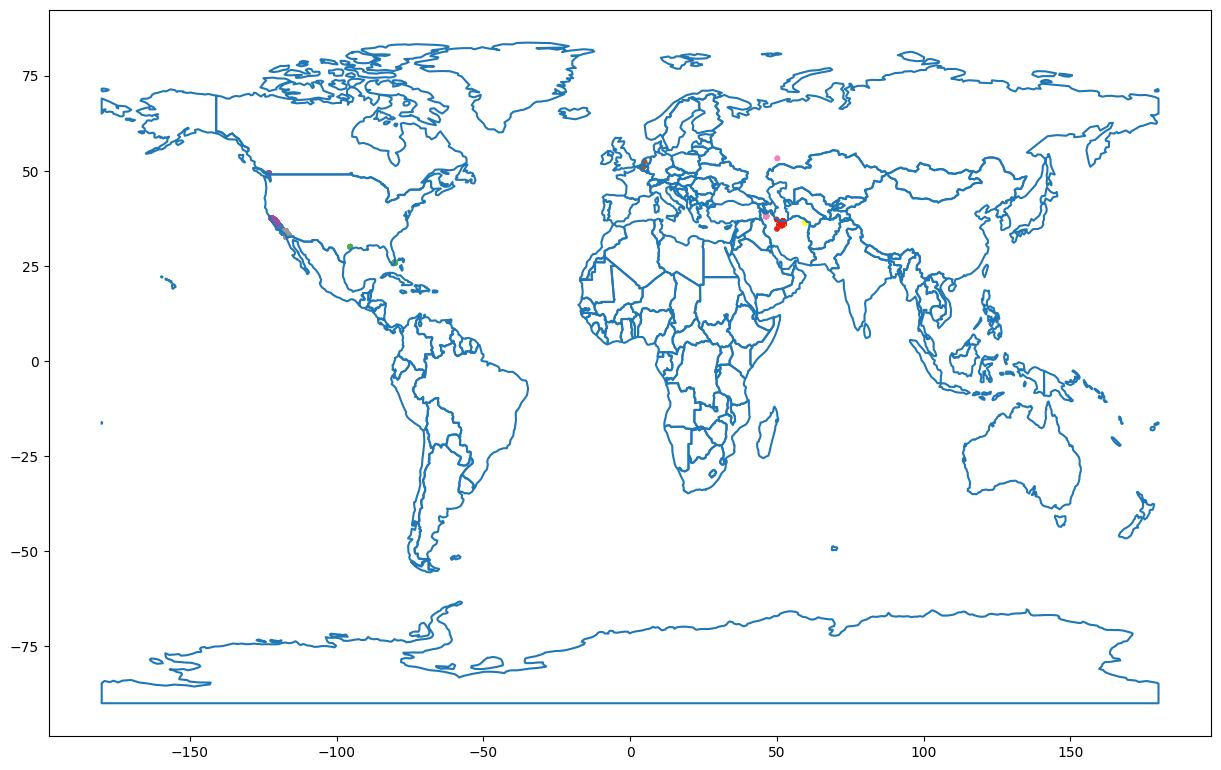

In [58]:
import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(df_locations['Longitude'], df_locations['Latitude'])]
gdf = gpd.GeoDataFrame(df_locations, geometry=geometry)
gdf.crs = world.crs

fig, ax = plt.subplots(figsize=(15, 15))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, column=df_locations["Cluster"], cmap='Set1', markersize=10)
plt.show()